In [1]:
import numpy as np
from classy import Class
from Francisco import trapezoid, right_rectangle, factors, xy_values,xy_values_old
import scipy.interpolate as sp
import matplotlib.pyplot as plt
import os
import numpy as np
import numba as nb
import ODEsolver as solve
from run import g, temp, gs, gss
from run import with_spline_ODE, steps_taken
from Emma import sterile_production

In [2]:
M_sol = 1.989e30 # solar mass in kg
Mpc = 3.086e22 # Mpc in m
c=np.logspace(-11.3,-5, 40)
kvec = np.logspace(-4,np.log10(100),100)
measured_omegacdm=.1188
Sig_8 = 0.811
A_s = 2.1e-9

In [3]:
commonsettings = {
          'N_ncdm':1,
          'use_ncdm_psd_files': 1,
          'm_ncdm': 7100,
          'T_ncdm':0.7,
          'output':'mPk',
          'P_k_max_1/Mpc':100.0,
          ## The next line should be uncommented fgor higher precision (but significantly slower running)
          'ncdm_fluid_approximation':3,
          ## You may uncomment this line to get more info on the ncdm sector from Class:
          'background_verbose':1,
          'Maximum q':100
         } 

In [4]:
def ideal_sigma8 (spec_file, omega_h_h):
    
    NH = Class()
        #use method .set() to 
    NH.set(commonsettings)
    othersettings = { 'ncdm_psd_filenames': spec_file,
                      'omega_cdm': measured_omegacdm - omega_h_h, 
                      'omega_ncdm': omega_h_h, 
                      'A_s': 2.1e-9,
                    }

    #use method .compute() to get data for my specific 'Spec-' file
    NH.set(othersettings)
    NH.compute()

    Sigma8_value = NH.sigma8()
    print("",Sigma8_value,"")
    
    ideal_value = ((Sig_8)/(Sigma8_value))**2*(A_s)
    
    NH.struct_cleanup()
    
    return ideal_value

In [5]:
def make_Pk(spec_file,omega_h_h, dict_name):
    
    kvec = np.logspace(-4,np.log10(100),100)
    
    
    othersettings = { 'ncdm_psd_filenames': spec_file,
                      'omega_cdm': measured_omegacdm - omega_h_h, 
                      'omega_ncdm': omega_h_h, 
                      'A_s': ideal_sigma8(spec_file, omega_h_h),
                    }
    
    for key, value in othersettings.items():
        print(key, ' : ', value)
    for key, value in commonsettings.items():
        print(key, ' : ', value)
    
    # array of k values in 1/Mpc


    NH = Class()
    NH.set(commonsettings)
    NH.set(othersettings)
    NH.compute()
    
    new_sig8 = NH.sigma8()
    pkNH = [] 
    
        #MPk- Matter Power Spectrum
    for k in kvec:
        pkNH.append(NH.pk(k,0.))
    h = NH.h()
    
    
    
    values_dict = {
                    'age': NH.age(),
                    'h': NH.h(),
                    'n_s': NH.n_s(),
                    'Neff': NH.Neff(),
                    'Omega0_cdm': NH.Omega0_cdm(),
                    'Omega0_k': NH.Omega0_k(),
                    'Omega0_m': NH.Omega0_m(),
                    'Omega_b': NH.Omega_b(),
                    'omega_b': NH.omega_b(),
                    'Omega_g': NH.Omega_g(),
                    'Omega_lambda': NH.Omega_Lambda(),
                    'Omega_m': NH.Omega_m(),
                    'Omega_r': NH.Omega_r(),
                    'rs_drag': NH.rs_drag(),
                    'Sigma8': NH.sigma8(),
                    'Sigma8_cb': NH.sigma8_cb(),
                    'T_cmb': NH.T_cmb(),
                    'tau_reio': NH.tau_reio(),
                    'theta_s_100': NH.theta_s_100(),
                    'theta_star_100': NH.theta_star_100(),
                    'pk': pkNH,
                    'k':kvec
                    }
    #this method clears the commonsettings out of the set method, so that we can load a new file 
    NH.struct_cleanup() 
    
    #saving the dictionary that we created above to a .npz file
    np.savez(dict_name + '.npz',Class_values = values_dict)
    

    np.save(spec_file+ '-Pknew',np.array(pkNH))
    np.save(spec_file+'-knew',kvec)
    
    return new_sig8

In [112]:
def trap(f,x):
    integral = 0
    for i in range(1,len(f)):
        integral += 0.5 * (f[i] + f[i-1]) * (x[i] - x[i-1])
    return integral

def R(M):
    c = 2.5
    G = 6.67e-11 # m^3 / kg / s^2
    H100 = 100 * (1000/Mpc) # km/s/Mpc -> 1/s
    omegah2 = 0.1188

    rhobar = omegah2 * 3 * H100**2 / (8 * np.pi * G) / M_sol * Mpc**3 # kg / m^3 -> M_sol / Mpc^3
    return (3 * M / (4 * np.pi * rhobar * c**3))**(1/3) # Mpc

def W(k,R):
        if np.isscalar(k):
            if k * R > 1:
                return 0
            else:
                return 1
        else:
            result = np.zeros(len(k))
            for i in range(len(k)-1):
                if k[i] * R < 1 and k[i+1] * R > 1:
                    result[i] = (1 - k[i] * R)/(k[i+1]*R - k[i]*R)
                elif k[i] * R < 1:
                    result[i] = 1
            return result
        
def S(M,k_vals,Pk_vals):
        Rv = R(M)
        
        integrand = k_vals**2 * Pk_vals * W(k_vals, Rv)**2 / (2 * ( np.pi**2))
        return trap(integrand,k_vals)


def dNdlnM(M,M0,P_spline, k_vals, Pk_vals):
    Rv = R(M)
    return 1 / 44.5 / (6 * np.pi**2) * (M0 / M) / Rv**3 / np.sqrt(2 * np.pi * ( S(M,k_vals,Pk_vals) - S(M0,k_vals,Pk_vals))) * P_spline(1/Rv)


def integrating(k_vals, Pk_vals, CLASS_data):    

    values = np.load(CLASS_data + '.npz', allow_pickle = True)
    
    h = values['Class_values'].item()['h']
    
    M0 = 1.77e12/h # M_sol*h^-1
    
    P_spline  = sp.CubicSpline(k_vals,Pk_vals)
    
    lnM_vals = np.linspace(np.log(1e8/h),np.log(M0))
    sv = np.zeros(len(lnM_vals)-1)
    for i in range(len(sv)):
        sv[i] = S(np.exp(lnM_vals[i]),k_vals,Pk_vals)- S(np.exp(lnM_vals[-1]),k_vals,Pk_vals)
    
    integrand = np.zeros(len(lnM_vals)-1)
    
    for i in range(len(integrand)):
        integrand[i] = dNdlnM(np.exp(lnM_vals[i]),M0,P_spline,k_vals,Pk_vals)
        
    integral = trap(integrand,lnM_vals[:-1])
                
    return integral, integrand, sv, lnM_vals

In [113]:
def Bella_2(file_name, k): ##.npz as first input and step size as the second
    
    dat = np.load('Neutrino Data/' + file_name)

    omega_h_h = dat['omega_h2']
    a,b,c,d,e = xy_values(file_name, k)
    np.savetxt("Spec", np.column_stack((a,b)))
    spec_file  = 'Spec'
    
    make_Pk(spec_file, omega_h_h,'CLASS_values')
    
    k_vals = np.load('Spec-knew.npy')
    Pk_vals = np.load('Spec-Pknew.npy')
    alpha, beta, gamma, delta = integrating(k_vals, Pk_vals, 'CLASS_values')
    
    return alpha, beta, gamma, delta

0.0026648604811727156

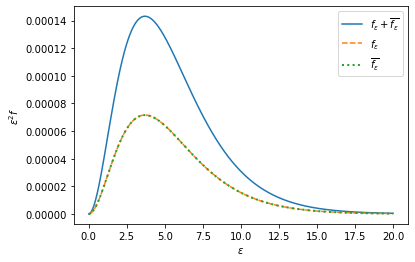

In [82]:
sterile_production(1000, 'electron', 0.0071, 10**(-10), 1e-20, make_plot=True, folder_name = "Neutrino Data")

In [114]:
def file_name():
    file_str = []
    length = os.listdir('Neutrino Data/')
    for i in range(len(length)):
        curr = length[i]
        file_str.append(curr)
    return file_str


file_names = file_name()
file_name = str(file_names[2])
print(file_name)
dat = np.load('Neutrino Data/' + file_name)

electronx1e-20x1e-10.npz


In [115]:
w,x,y,z = Bella_2(file_name, 4)

 0.8194957865773755 
ncdm_psd_filenames  :  Spec
omega_cdm  :  0.11613513951882729
omega_ncdm  :  0.0026648604811727156
A_s  :  2.05668392274887e-09
N_ncdm  :  1
use_ncdm_psd_files  :  1
m_ncdm  :  7100
T_ncdm  :  0.7
output  :  mPk
P_k_max_1/Mpc  :  100.0
ncdm_fluid_approximation  :  3
background_verbose  :  1
Maximum q  :  100


In [116]:
print(w)

151.16759779058503


In [117]:
file_name_old = 'Neutrino Data/1x0.00049x3e-09-data.npz'

def CDM_make_Pk(spec_file,omega_h_h,dict_name):
    
    kvec = np.logspace(-4,np.log10(100),100)
    
    
    othersettings = { 'ncdm_psd_filenames': spec_file,
                      'omega_cdm': measured_omegacdm - omega_h_h, 
                      'omega_ncdm': omega_h_h, 
                      'A_s': ideal_sigma8(spec_file, omega_h_h),
                    }
    
    for key, value in othersettings.items():
        print(key, ' : ', value)
    for key, value in commonsettings.items():
        print(key, ' : ', value)
    
    # array of k values in 1/Mpc


    NH = Class()
    NH.set(commonsettings)
    NH.set(othersettings)
    NH.compute()
    
    new_sig8 = NH.sigma8()
    pkNH = [] 
    
        #MPk- Matter Power Spectrum
    for k in kvec:
        pkNH.append(NH.pk(k,0.))
    h = NH.h()
    
    
    
    values_dict = {
                    'age': NH.age(),
                    'h': NH.h(),
                    'n_s': NH.n_s(),
                    'Neff': NH.Neff(),
                    'Omega0_cdm': NH.Omega0_cdm(),
                    'Omega0_k': NH.Omega0_k(),
                    'Omega0_m': NH.Omega0_m(),
                    'Omega_b': NH.Omega_b(),
                    'omega_b': NH.omega_b(),
                    'Omega_g': NH.Omega_g(),
                    'Omega_lambda': NH.Omega_Lambda(),
                    'Omega_m': NH.Omega_m(),
                    'Omega_r': NH.Omega_r(),
                    'rs_drag': NH.rs_drag(),
                    'Sigma8': NH.sigma8(),
                    'Sigma8_cb': NH.sigma8_cb(),
                    'T_cmb': NH.T_cmb(),
                    'tau_reio': NH.tau_reio(),
                    'theta_s_100': NH.theta_s_100(),
                    'theta_star_100': NH.theta_star_100(),
                    'pk': pkNH,
                    'k':kvec
                    }
    #this method clears the commonsettings out of the set method, so that we can load a new file 
    NH.struct_cleanup() 

    #saving the dictionary that we created above to a .npz file
    np.savez(dict_name + '.npz',Class_values = values_dict)


    np.save(spec_file+ '-PknewCDM',np.array(pkNH))
    np.save(spec_file+'-knewCDM',kvec)
    
    return new_sig8






def Bella_Old_Structure(file_name, k): 
    
    dat = np.load(file_name)

    omega_h_h = dat['omega_s']
    a,b,c,d,e = xy_values_old(file_name, k)
    np.savetxt("Spec", np.column_stack((a,b)))
    spec_file  = 'Spec'
    
    CDM_make_Pk(spec_file, omega_h_h, 'CDM_CLASS_Values')
    
    k_vals = np.load('Spec-knewCDM.npy')
    
    Pk_vals = np.load('Spec-PknewCDM.npy')
    
    mu, nu, xi, pi = integrating(k_vals,Pk_vals,'CDM_CLASS_Values')
    
    return mu, nu, xi, pi

In [118]:
alpha, beta, gamma, delta = Bella_Old_Structure(file_name_old, 4)

 0.7537938931744148 
ncdm_psd_filenames  :  Spec
omega_cdm  :  0.05941682610033301
omega_ncdm  :  0.05938317389966699
A_s  :  2.430836639371758e-09
N_ncdm  :  1
use_ncdm_psd_files  :  1
m_ncdm  :  7100
T_ncdm  :  0.7
output  :  mPk
P_k_max_1/Mpc  :  100.0
ncdm_fluid_approximation  :  3
background_verbose  :  1
Maximum q  :  100


In [119]:
print(alpha)

41.181503945044796


[1.00000000e-04 1.14975700e-04 1.32194115e-04 1.51991108e-04
 1.74752840e-04 2.00923300e-04 2.31012970e-04 2.65608778e-04
 3.05385551e-04 3.51119173e-04 4.03701726e-04 4.64158883e-04
 5.33669923e-04 6.13590727e-04 7.05480231e-04 8.11130831e-04
 9.32603347e-04 1.07226722e-03 1.23284674e-03 1.41747416e-03
 1.62975083e-03 1.87381742e-03 2.15443469e-03 2.47707636e-03
 2.84803587e-03 3.27454916e-03 3.76493581e-03 4.32876128e-03
 4.97702356e-03 5.72236766e-03 6.57933225e-03 7.56463328e-03
 8.69749003e-03 1.00000000e-02 1.14975700e-02 1.32194115e-02
 1.51991108e-02 1.74752840e-02 2.00923300e-02 2.31012970e-02
 2.65608778e-02 3.05385551e-02 3.51119173e-02 4.03701726e-02
 4.64158883e-02 5.33669923e-02 6.13590727e-02 7.05480231e-02
 8.11130831e-02 9.32603347e-02 1.07226722e-01 1.23284674e-01
 1.41747416e-01 1.62975083e-01 1.87381742e-01 2.15443469e-01
 2.47707636e-01 2.84803587e-01 3.27454916e-01 3.76493581e-01
 4.32876128e-01 4.97702356e-01 5.72236766e-01 6.57933225e-01
 7.56463328e-01 8.697490

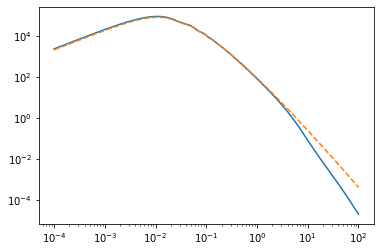

In [120]:
values = np.load('CLASS_Values.npz', allow_pickle = True)

pk = values['Class_values'].item()['pk']
k = values['Class_values'].item()['k']

cdm_values = np.load('CDM_CLASS_Values.npz', allow_pickle = True)

pk_cdm = cdm_values['Class_values'].item()['pk']
k_cdm = cdm_values['Class_values'].item()['k']

print(k_cdm)
plt.figure()
plt.loglog(k_cdm,pk_cdm)
plt.loglog(k,pk, linestyle = '--')
plt.show()

In [121]:
LambdaCDM = Class()
LambdaCDM.set({'omega_b':0.022032,'omega_cdm':0.12038,'h':0.67556,'A_s':2.215e-9,'n_s':0.9619,'tau_reio':0.0925})
LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':100.0})
LambdaCDM.compute()
kk = np.logspace(-4,np.log10(100),100)
Pk = []
h  = LambdaCDM.h()
for k in kk: 
    Pk.append(LambdaCDM.pk(k,0.))

    
LambdaCDM.struct_cleanup()
LambdaCDM.empty() 

In [122]:
print(k_cdm,kk)

[1.00000000e-04 1.14975700e-04 1.32194115e-04 1.51991108e-04
 1.74752840e-04 2.00923300e-04 2.31012970e-04 2.65608778e-04
 3.05385551e-04 3.51119173e-04 4.03701726e-04 4.64158883e-04
 5.33669923e-04 6.13590727e-04 7.05480231e-04 8.11130831e-04
 9.32603347e-04 1.07226722e-03 1.23284674e-03 1.41747416e-03
 1.62975083e-03 1.87381742e-03 2.15443469e-03 2.47707636e-03
 2.84803587e-03 3.27454916e-03 3.76493581e-03 4.32876128e-03
 4.97702356e-03 5.72236766e-03 6.57933225e-03 7.56463328e-03
 8.69749003e-03 1.00000000e-02 1.14975700e-02 1.32194115e-02
 1.51991108e-02 1.74752840e-02 2.00923300e-02 2.31012970e-02
 2.65608778e-02 3.05385551e-02 3.51119173e-02 4.03701726e-02
 4.64158883e-02 5.33669923e-02 6.13590727e-02 7.05480231e-02
 8.11130831e-02 9.32603347e-02 1.07226722e-01 1.23284674e-01
 1.41747416e-01 1.62975083e-01 1.87381742e-01 2.15443469e-01
 2.47707636e-01 2.84803587e-01 3.27454916e-01 3.76493581e-01
 4.32876128e-01 4.97702356e-01 5.72236766e-01 6.57933225e-01
 7.56463328e-01 8.697490

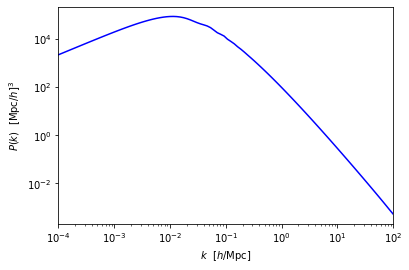

In [123]:
plt.figure(2)
plt.xscale('log');plt.yscale('log');plt.xlim(kk[0],kk[-1])
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
plt.plot(kk,Pk,'b-')
plt.savefig('warmup_cltt.pdf')

In [79]:
plt.savefig('warmup_cltt.pdf')

<Figure size 432x288 with 0 Axes>

In [124]:
def integrating_LCDM(k_vals, Pk_vals):     
    
    M0 = 1.77e12/h # M_sol*h^-1
    
    P_spline  = sp.CubicSpline(k_vals,Pk_vals)
    
    lnM_vals = np.linspace(np.log(1e8),np.log(M0))
    sv = np.zeros(len(lnM_vals)-1)
    for i in range(len(sv)):
        sv[i] = S(np.exp(lnM_vals[i]),k_vals,Pk_vals)- S(np.exp(lnM_vals[-1]),k_vals,Pk_vals)
    
    integrand = np.zeros(len(lnM_vals)-1)
    
    for i in range(len(integrand)):
        integrand[i] = dNdlnM(np.exp(lnM_vals[i]),M0,P_spline,k_vals,Pk_vals)
        
    integral = trap(integrand,lnM_vals[:-1])
                
    return integral, integrand, sv, lnM_vals

In [125]:
nsh, integrand, sv, lnm_vals = integrating_LCDM(kk,Pk)
print(nsh) 

248.980928008189
